In [ ]:
# Goal

'''

Steps:

1) Explore data
3) Test for benchmark model
2) Build neural network
3) Hyperparameter tunning

'''

'\nBuild the most performant neural network, with least amount of features, and the lightest model for edge deployment.\n\nSteps:\n\n1) Explore data\n2) Test benchmark models\n3) Leverage best benchmark model for initial feature selection\n4) Build series of neural networks\n5) Leverage most performant neural network to select least number of features without sacrificing accuracy\n6) Hyperparameter tunning\n7) Quantisation for edge deployment\n\n'

In [ ]:

# Dataset info

'''
The experiments have been carried out with a group of 30 volunteers, each person performed six activities
(WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING)
wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope,
the author captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz.
The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly
partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

This experiment will classify the movements with and without a custom set of feature extraction.

'''

'\nThe experiments have been carried out with a group of 30 volunteers, each person performed six activities\n(WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING)\nwearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope,\nthe author captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz.\nThe experiments have been video-recorded to label the data manually. The obtained dataset has been randomly\npartitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.\n\nThis experiment will classify the movements with and without a custom set of feature extraction.\n\n'

In [ ]:
# Install Intel package for SKLearn performance gains

!pip install --quiet scikit-learn-intelex

from sklearnex import patch_sklearn
patch_sklearn()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 7.6 MB/s eta 0:00:00


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
# Import required libraries

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch

from sklearn import tree
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

from keras.layers import Dense, Dropout
from keras.losses import mean_squared_error, hinge
from keras.optimizers import Adam, RMSprop

from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical

import warnings

warnings.filterwarnings("ignore", message="X does not have valid feature names")


In [ ]:
# Connect GDrive

from google.colab import drive
drive.mount('/content/gdrive')
IN_COLAB = True
source_dir = '/content/gdrive/MyDrive/Study/Code/Data Science Code/activity_recognition/'

os.path.isdir(source_dir)

Mounted at /content/gdrive


True

In [ ]:
#
# Load train test datasets
#

subject_trian_path = source_dir + 'train.csv'
subject_train_df = pd.read_csv(subject_trian_path)
subject_train_df = subject_train_df.drop('subject', axis =1)

subject_test_path = source_dir + 'test.csv'
subject_test_df = pd.read_csv(subject_test_path)
subject_test_df = subject_test_df.drop('subject', axis =1)


# Print information
print('Shape of Train DF:', subject_train_df.shape)
print('Shape of Test DF:', subject_test_df.shape)

subject_train_df.head()

Shape of Train DF: (7352, 562)
Shape of Test DF: (2947, 562)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


In [ ]:
#
# Exploratory Analysis
#

'''
This stage involves understanding the dataset, checking for patterns, distributions, and anomalies,
and gaining insights to guide subsequent modeling decisions by visualizing and analyzing the data.
'''

In [ ]:
# View unique labels

subject_test_df['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [ ]:
# Assign numerical value to label

activity_mapping = {
    'STANDING': 0,
    'SITTING': 1,
    'LAYING': 2,
    'WALKING': 3,
    'WALKING_DOWNSTAIRS': 4,
    'WALKING_UPSTAIRS': 5
}

# Use the replace function to map
subject_train_df['Activity'] = subject_train_df['Activity'].replace(activity_mapping)
subject_test_df['Activity'] = subject_test_df['Activity'].replace(activity_mapping)

# Print information
print('Shape of Train DF:', subject_train_df.shape)
print('Shape of Test DF:', subject_test_df.shape)

subject_train_df.head()

Shape of Train DF: (7352, 562)
Shape of Test DF: (2947, 562)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,0
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,0
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,0
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,0
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,0


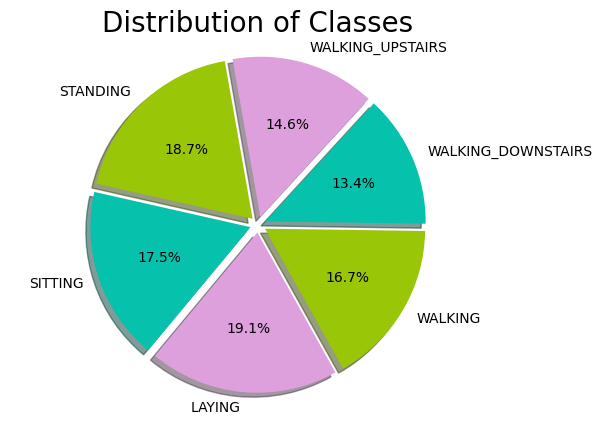

In [ ]:

# View distribution of classes

colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']

# Data to plot
labels = 'STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'

sizes = [len(subject_train_df[subject_train_df['Activity'] == 0]),
         len(subject_train_df[subject_train_df['Activity'] == 1]),
         len(subject_train_df[subject_train_df['Activity'] == 2]),
         len(subject_train_df[subject_train_df['Activity'] == 3]),
         len(subject_train_df[subject_train_df['Activity'] == 4]),
         len(subject_train_df[subject_train_df['Activity'] == 5])]

colors = ['#9ac608', '#06C2AC', '#DDA0DD']
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05)

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=100)

plt.axis('equal')
plt.title('Distribution of Classes', fontsize = 20)
plt.show()

In [ ]:
print([x for x in subject_train_df.columns if 'Acc' in x and 'mean' in x])


['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-Z', 'tBodyAccJerk-mean()-X', 'tBodyAccJerk-mean()-Y', 'tBodyAccJerk-mean()-Z', 'tBodyAccMag-mean()', 'tGravityAccMag-mean()', 'tBodyAccJerkMag-mean()', 'fBodyAcc-mean()-X', 'fBodyAcc-mean()-Y', 'fBodyAcc-mean()-Z', 'fBodyAcc-meanFreq()-X', 'fBodyAcc-meanFreq()-Y', 'fBodyAcc-meanFreq()-Z', 'fBodyAccJerk-mean()-X', 'fBodyAccJerk-mean()-Y', 'fBodyAccJerk-mean()-Z', 'fBodyAccJerk-meanFreq()-X', 'fBodyAccJerk-meanFreq()-Y', 'fBodyAccJerk-meanFreq()-Z', 'fBodyAccMag-mean()', 'fBodyAccMag-meanFreq()', 'fBodyBodyAccJerkMag-mean()', 'fBodyBodyAccJerkMag-meanFreq()']


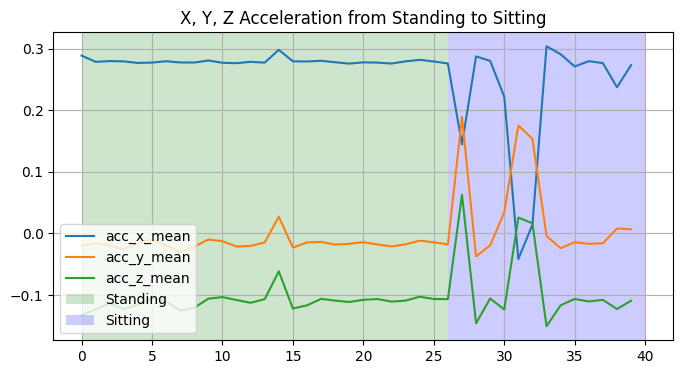

In [ ]:

# Visualise X, Y, Z acceleration from Standing to Sitting

# Extract the time series data for the x-axis
time = [x for x in range(40) ]
# Create a figure and an axis

fig = plt.figure(figsize=(8, 4))
# Add an axis to the figure
ax = fig.add_subplot(111)
x = subject_train_df['tBodyAcc-mean()-X'].values
y = subject_train_df['tBodyAcc-mean()-Y'].values
z = subject_train_df['tBodyAcc-mean()-Z'].values

# Plot the first column
ax.plot(time, x[:40], label='acc_x_mean')
# Plot the second column
ax.plot(time, y[:40], label='acc_y_mean')
# Plot the third column
ax.plot(time, z[:40], label='acc_z_mean')
ax.axvspan(0, 26, facecolor='g', alpha=0.2, label='Standing')
ax.axvspan(26, 40, facecolor='b', alpha=0.2, label='Sitting')

# Add a title
plt.title('X, Y, Z Acceleration from Standing to Sitting')

# Add a legend
ax.legend(loc='lower left')
ax.grid(True)

# Show the plot
plt.show()

In [ ]:
print([x for x in subject_train_df.columns if 'Gyro' in x and 'mean' in x])


['tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-mean()-Z', 'tBodyGyroJerk-mean()-X', 'tBodyGyroJerk-mean()-Y', 'tBodyGyroJerk-mean()-Z', 'tBodyGyroMag-mean()', 'tBodyGyroJerkMag-mean()', 'fBodyGyro-mean()-X', 'fBodyGyro-mean()-Y', 'fBodyGyro-mean()-Z', 'fBodyGyro-meanFreq()-X', 'fBodyGyro-meanFreq()-Y', 'fBodyGyro-meanFreq()-Z', 'fBodyBodyGyroMag-mean()', 'fBodyBodyGyroMag-meanFreq()', 'fBodyBodyGyroJerkMag-mean()', 'fBodyBodyGyroJerkMag-meanFreq()']


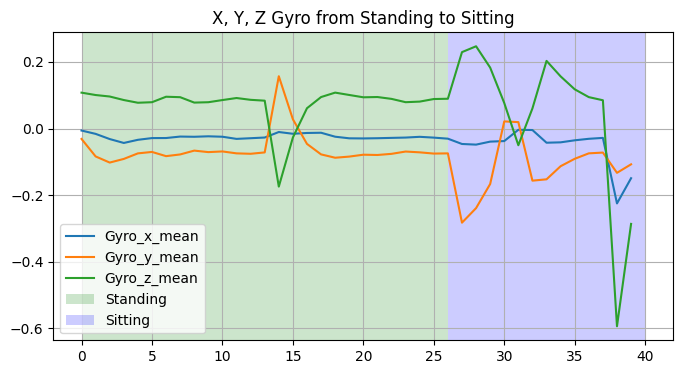

In [ ]:

# Visualise X, Y, Z Gyro from Standing to Sitting


# Extract the time series data for the x-axis
time = [x for x in range(40) ]
# Create a figure and an axis
#fig, ax = plt.subplots()
fig = plt.figure(figsize=(8, 4))
# Add an axis to the figure
ax = fig.add_subplot(111)
x = subject_train_df['tBodyGyro-mean()-X'].values
y = subject_train_df['tBodyGyro-mean()-Y'].values
z = subject_train_df['tBodyGyro-mean()-Z'].values
#colors = second_df_train['activity']
# Plot the first column
ax.plot(time, x[:40], label='Gyro_x_mean')
# Plot the second column
ax.plot(time, y[:40], label='Gyro_y_mean')
# Plot the third column
ax.plot(time, z[:40], label='Gyro_z_mean')
ax.axvspan(0, 26, facecolor='g', alpha=0.2, label='Standing')
ax.axvspan(26, 40, facecolor='b', alpha=0.2, label='Sitting')

# Add a title
plt.title('X, Y, Z Gyro from Standing to Sitting')

# Add a legend
ax.legend(loc='lower left')
ax.grid(True)

# Show the plot
plt.show()

In [ ]:
#
# Test For Benchamrk Models
#

'''
Here, standard or baseline models are applied to the data to establish a performance baseline,
aiding in comparison with more complex models and understanding the complexity required for solving the problem.
'''

def model_selector(df1, df2, mod_type, cols = None):

    df1 = df1.copy()
    df2 = df2.copy()

    y = df1['Activity']
    x = df1.drop('Activity', axis = 1)

    yt = df2['Activity']
    xt = df2.drop('Activity', axis = 1)

    if cols is not None and len(cols) > 0:
      x = x[cols]
      xt = xt[cols]

    if mod_type == 'rf':

      etc = RandomForestClassifier()
      params = {
          'n_estimators': [100, 300],
          'max_depth': [None, 10],
      }
    elif mod_type == 'svc':

      etc = SVC()
      params = {
          'C': [0.001, 1],
          'kernel': ['rbf'],
      }
    elif mod_type == 'xg':

      etc = XGBClassifier()
      params = {
          'n_estimators': [100,  300],
          'max_depth': [3, 5],
          'learning_rate': [0.1,  0.001],
      }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(etc, params, cv=3)
    grid_search.fit(x, y)
    y_preds = grid_search.predict(xt)
    # preds_ints = [np.round(x) for x in y_preds]

    # Get the best estimator and its feature importances
    best_etc = grid_search.best_estimator_

    acc_score = np.round(accuracy_score(y_true=yt, y_pred=y_preds), 2)

    return acc_score, best_etc

In [ ]:
#
# Test Selection of Base Models
#

acc_score_test_rf, best_params_rf = model_selector(subject_train_df, subject_test_df, 'rf')
acc_score_test_svc, best_params_svc = model_selector(subject_train_df, subject_test_df, 'svc')


In [ ]:
print(f'SVC Score: {acc_score_test_svc}, Params: {best_params_svc}')
print(f'RF Score: {acc_score_test_rf}, Params: {best_params_rf}')

SVC Score: 0.95, Params: SVC(C=1)
RF Score: 0.92, Params: RandomForestClassifier(max_depth=10, n_estimators=300)


In [ ]:
#
# Build Base Tensor Model
#

In [ ]:

# Function for plotting accuracy vs loss

def plot_history(history, d_type):
    """
    Plot training history.

    Args:
        history (tf.keras.callbacks.History): History object returned by model.fit.
        d_type (str): Type of plot to create ('lr' or 'main').
    """
    plt.figure(figsize=(18, 2))
    ax = plt.subplot(121)

    if d_type == 'lr':
        loss = history.history['val_loss']
        acc = history.history['val_accuracy']

        ax.plot(lr_shed_test, loss, label='Validation Loss', linestyle='--', color='blue')
        ax.plot(lr_shed_test, acc, label='Validation Accuracy', color='orange', alpha=0.6)

    elif d_type == 'main':
        loss = history.history['loss']
        acc = history.history['accuracy']
        val_loss = history.history['val_loss']
        val_acc = history.history['val_accuracy']

        ax.plot(range(len(loss)), loss, label='Training Loss', linestyle='--', color='blue', alpha=0.7)
        ax.plot(range(len(loss)), acc, label='Training Accuracy', color='blue', alpha=0.6)
        ax.plot(range(len(loss)), val_loss, label='Validation Loss', linestyle='--', color='orange')
        ax.plot(range(len(loss)), val_acc, label='Validation Accuracy', color='orange', alpha=0.6)

    ax.legend(loc='lower right', bbox_to_anchor=(1.22, 0.45), fontsize=9)
    ax.set_ylim(0, 1)  # Set y-axis limit to 1
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Metrics')
    ax.set_title('Training History')
    plt.show()

# Funciton for removing label from train

def get_new_df(subject_train_df, subject_test_df, cols):

    y_train = subject_train_df['Activity']
    x_train = subject_train_df.drop('Activity', axis = 1)

    y_test = subject_test_df['Activity']
    x_test = subject_test_df.drop('Activity', axis = 1)

    if cols is not None:
       x_train = subject_train_df[cols]
       x_test = subject_test_df[cols]

    return x_train, y_train, x_test, y_test



In [ ]:
# First, learning rate is tunned by increasing LR and monitoring loss

# Function for testing learnig rate, returns best
def test_lr_nm(train_df, test_df, cols, lr, batch_s, weights):

    # weights = [150, 150, 150]
    x, y, xt, yt = get_new_df(train_df, test_df, cols)

    y_one_hot = to_categorical(y, num_classes=6)
    yt_one_hot = to_categorical(yt, num_classes=6)

    shape_imp = x.shape[1]
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr[0] * 10**(epoch /lr[1]))

    model_lr = tf.keras.Sequential([
        tf.keras.layers.Dense(shape_imp, activation='relu'),
        tf.keras.layers.Dense(weights[0], activation='relu'),
        tf.keras.layers.Dense(weights[1], activation='relu'),
        tf.keras.layers.Dense(weights[2], activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')    ])

    # Setup the training parameters
    model_lr.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])

    history = model_lr.fit(x ,y_one_hot , epochs=10,
                          batch_size = batch_s, validation_data=(xt, yt_one_hot),
                           callbacks=[lr_schedule], verbose = False)


    plot_history(history, 'lr')


In [ ]:
# Shedule for LR samples
lr_shed_test= [1e-8 * 10**(x / 1.5) for x in range(10)]
lr_shed_test

[1e-08,
 4.641588833612779e-08,
 2.1544346900318832e-07,
 1e-06,
 4.641588833612778e-06,
 2.1544346900318847e-05,
 0.0001,
 0.0004641588833612782,
 0.002154434690031882,
 0.01]

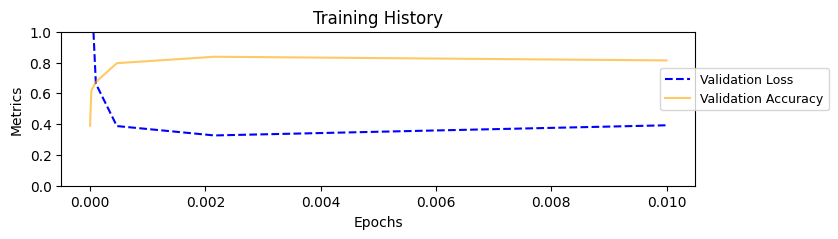

In [ ]:
# Run LR model

test_lr_nm(subject_train_df, subject_test_df, columns_kb_40, [1e-8, 1.5], 16, [40, 40, 40])

In [ ]:
subject_train_df.shape

(7352, 562)

In [ ]:
# Simple tensor model is tested with differnt hyperparamters

def tensor_model_nm(train_df, test_df, hparams, feats, tuning):


    x, y, xt, yt = get_new_df(train_df, test_df, feats)

    shape_imp = x.shape[1]

    if tuning:
        if hparams[HP_NUM_UNITS1] == 0:
          weights = [shape_imp, shape_imp, shape_imp]

        elif hparams[HP_NUM_UNITS1] == 1:
          weights = [shape_imp, int(shape_imp*0.5), int(shape_imp*0.25)]

        elif hparams[HP_NUM_UNITS1] == 2:
          weights = [shape_imp*2, shape_imp, int(shape_imp*0.5)]

        batch = hparams[HP_BATCH]

        ep = hparams[HP_EP]

        model_type = hparams[HP_MODEL]

        dp = hparams[HP_DP]

    else:

        if hparams[0] == 0:
          weights = [shape_imp, shape_imp, shape_imp]

        elif hparams[0] == 1:
          weights = [shape_imp, int(shape_imp*0.5), int(shape_imp*0.25)]

        elif hparams[0] == 2:
          weights = [shape_imp*2, shape_imp, int(shape_imp*0.5)]

        batch = hparams[1]

        ep = hparams[2]

        model_type = hparams[3]

        dp = hparams[4]

    activ = 'elu'

    # Data is already randomised so slicing for train val split
    len_x_cutoff = int(x.shape[0]*0.8)
    xv = x.iloc[len_x_cutoff:]
    x = x.iloc[:len_x_cutoff]

    yv = y.iloc[len_x_cutoff:]
    y = y.iloc[:len_x_cutoff]


    y_one_hot = to_categorical(y, num_classes=6)
    yv_one_hot = to_categorical(yv, num_classes=6)
    yt_one_hot = to_categorical(yt, num_classes=6)

    shape_imp = x.shape[1]

    if model_type == 1:

        model = tf.keras.Sequential([
            Dense(shape_imp, activation = activ),
            Dropout(dp),
            Dense(weights[0], activation = activ),
            Dropout(dp),
            Dense(weights[1], activation = activ),
            Dropout(dp),
            Dense(6, activation='softmax')    ])

    elif model_type == 2:

        model = tf.keras.Sequential([
            Dense(shape_imp, activation = activ),
            Dropout(dp),
            Dense(weights[0], activation = activ),
            Dropout(dp),
            Dense(weights[1], activation = activ),
            Dropout(dp),
            Dense(weights[2], activation = activ),
            Dropout(dp),
            Dense(6, activation='softmax')    ])

    elif model_type == 3:

        model = tf.keras.Sequential([
            Dense(shape_imp, activation = activ),
            Dropout(dp),
            Dense(weights[0], activation = activ),
            Dropout(dp),
            Dense(weights[1], activation = activ),
            Dropout(dp),
            Dense(weights[1], activation = activ),
            Dropout(dp),
            Dense(weights[2], activation = activ),
            Dropout(dp),
            Dense(6, activation='softmax')    ])

    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    history = model.fit(x,y_one_hot, validation_data =(xv,yv_one_hot),
                        batch_size = batch ,
                        epochs= ep, verbose = False )
    # history = model.fit(x,y_one_hot, batch_size = batch_s, epochs=ep )

    preds = model.predict(xt)
    pred_classes = np.round(preds)
    acc_out = np.round(accuracy_score(y_true=yt_one_hot, y_pred=pred_classes), 3)

    print(f'Accuracy score: {acc_out}')

    return pred_classes, model, history, acc_out


93/93 [==============================] - 1s 5ms/step
Accuracy score: 0.946


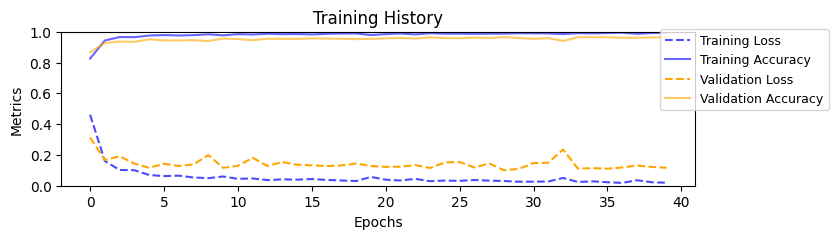

In [ ]:
# shape weights, batch, epochs, model type

params_40 = [ 0, 32, 40, 1, 0.0]

preds_40, model_40, history_40, acc_out_40 = tensor_model_nm(subject_train_df, subject_test_df, params_40, None, False)

plot_history(history_40, 'main')

In [ ]:
#
# Build RNN HParams
#

In [ ]:
from tensorboard.plugins.hparams import api as hp
import pickle

HP_NUM_UNITS1 = hp.HParam('num_units1', hp.Discrete([0, 1, 2]))
HP_BATCH = hp.HParam('batch', hp.Discrete([8, 16, 32]))
HP_EP = hp.HParam('ep', hp.Discrete([30, 50, 80]))
HP_MODEL = hp.HParam('model', hp.Discrete([1, 2, 3]))
HP_DP = hp.HParam('dp', hp.Discrete([0.0, 0.4]))
METRIC_ACCURACY = 'accuracy'


def run(hparams):

    hp.hparams(hparams)  # record the values used in this trial
    preds_40, model_40, history_40, acc_out_40 = tensor_model_nm(subject_train_df, subject_test_df,
                                                                hparams, None, True)

    return acc_out_40


if os.path.isfile(source_dir + 'tuning_files/hparams_tuning_rnn_simple_dp'):
  with open(source_dir + 'tuning_files/hparams_tuning_rnn_simple_dp', "rb") as file:
      hyperparameters_results = pickle.load(file)

      session_num = len(hyperparameters_results)

else:
  session_num = 0
  hyperparameters_results = []


tested_hyperparameters_results = [result[2] for result in hyperparameters_results]
#print(tested_hyperparameters)

for num_units1 in HP_NUM_UNITS1.domain.values:
  for ep in HP_EP.domain.values:
    # for activ in HP_ACTIV.domain.values:
      for batch in HP_BATCH.domain.values:
          for model in HP_MODEL.domain.values:
            for dp in HP_DP.domain.values:
                                      hparams = {
                                          HP_NUM_UNITS1: num_units1,
                                          HP_MODEL: model,
                                          HP_EP: ep,
                                          HP_BATCH: batch,
                                          HP_DP: dp,
                                      }

                                      # print('hparam set')

                                      # Then, in the loop:
                                      hparams_set = {h.name: hparams[h] for h in hparams}
                                      # print(hparams_set)

                                      if hparams_set in tested_hyperparameters_results:
                                          continue

                                      tested_hyperparameters_results.append(hparams_set)

                                      run_name = "run-%d" % session_num
                                      print('--- Starting trial: %s' % run_name)
                                      print({h.name: hparams[h] for h in hparams})

                                      #mean_acc, mean_error, mean_error_count, variance = run('logs/hparam_tuning/' + run_name, hparams)
                                      acc_out_40 = run(hparams)

                                      session_num += 1

                                      hyperparameters_results.append([session_num, acc_out_40, {h.name: hparams[h] for h in hparams}])

                                      # Save the list to a pickle file
                                      with open(source_dir + 'tuning_files/hparams_tuning_rnn_simple_dp', "wb") as file:
                                          pickle.dump(hyperparameters_results, file)


--- Starting trial: run-145
{'num_units1': 2, 'model': 2, 'ep': 50, 'batch': 8, 'dp': 0.4}
93/93 [==============================] - 1s 10ms/step
Accuracy score: 0.948
--- Starting trial: run-146
{'num_units1': 2, 'model': 3, 'ep': 50, 'batch': 8, 'dp': 0.4}
93/93 [==============================] - 1s 12ms/step
Accuracy score: 0.943
--- Starting trial: run-147
{'num_units1': 2, 'model': 1, 'ep': 50, 'batch': 16, 'dp': 0.4}
93/93 [==============================] - 1s 7ms/step
Accuracy score: 0.936
--- Starting trial: run-148
{'num_units1': 2, 'model': 2, 'ep': 50, 'batch': 16, 'dp': 0.4}
93/93 [==============================] - 1s 7ms/step
Accuracy score: 0.951
--- Starting trial: run-149
{'num_units1': 2, 'model': 3, 'ep': 50, 'batch': 16, 'dp': 0.4}
93/93 [==============================] - 1s 9ms/step
Accuracy score: 0.917
--- Starting trial: run-150
{'num_units1': 2, 'model': 1, 'ep': 50, 'batch': 32, 'dp': 0.4}
93/93 [==============================] - 1s 7ms/step
Accuracy score: 0.94

Number of itterations 162


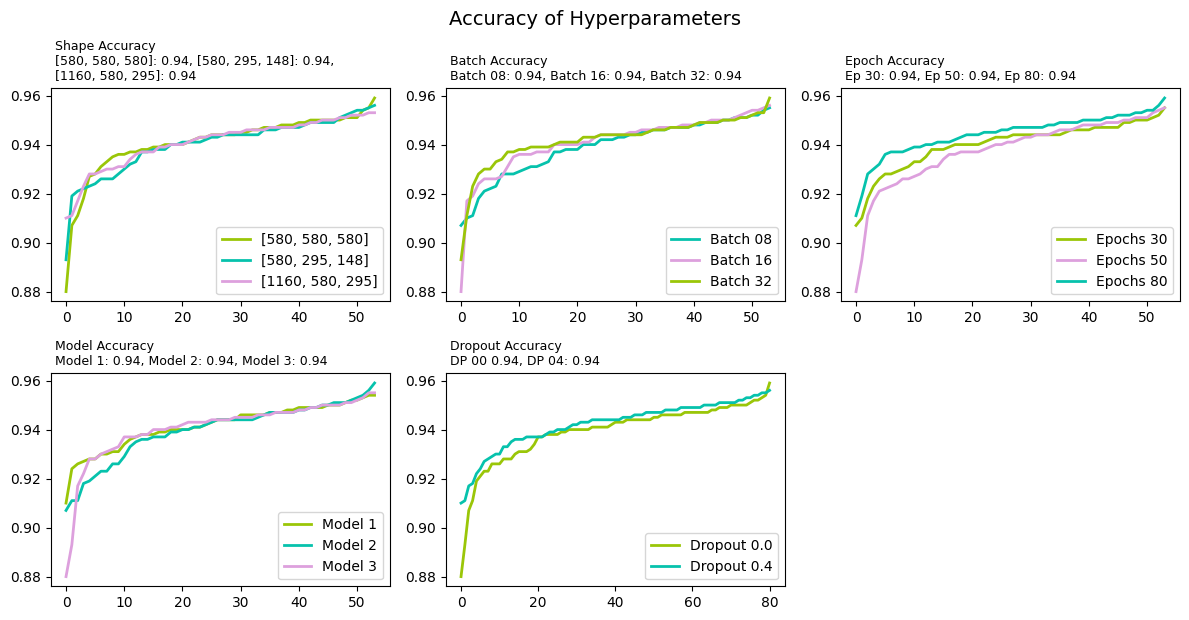

In [ ]:

# Display Tuning of HParamms

with open(source_dir + 'tuning_files/hparams_tuning_rnn_simple_dp', "rb") as file:
      hyperparameters_results = pickle.load(file)

def sum_mean(data):
  if len(data) != 0:
    return np.round(sum(data)/len(data), 2)

colors = ['#9ac608', '#06C2AC', '#DDA0DD']

# Set the plot size
plt.figure(figsize=(12, 6))
params_NUM_UNITS0 = [x[1] for x in hyperparameters_results if 'num_units1' in x[2] and x[2]['num_units1'] == 0]
params_NUM_UNITS1 = [x[1] for x in hyperparameters_results if 'num_units1' in x[2] and x[2]['num_units1'] == 1]
params_NUM_UNITS2 = [x[1] for x in hyperparameters_results if 'num_units1' in x[2] and x[2]['num_units1'] == 2]
plt.subplot(2, 3, 1)
sns.lineplot(x=range(len(params_NUM_UNITS0)), y=sorted(params_NUM_UNITS0), color=colors[0], linewidth=2, label='[580, 580, 580]')
sns.lineplot(x=range(len(params_NUM_UNITS1)), y=sorted(params_NUM_UNITS1), color=colors[1], linewidth=2, label='[580, 295, 148]')
sns.lineplot(x=range(len(params_NUM_UNITS2)), y=sorted(params_NUM_UNITS2), color=colors[2], linewidth=2, label='[1160, 580, 295]')
plt.title(f' Shape Accuracy \n [580, 580, 580]: {sum_mean(params_NUM_UNITS0)}, [580, 295, 148]: {sum_mean(params_NUM_UNITS1)}, \n [1160, 580, 295]: {sum_mean(params_NUM_UNITS2)}', loc = 'left', fontsize=9)
plt.legend()

params_acc_bt08 = [x[1] for x in hyperparameters_results if 'batch' in x[2] and x[2]['batch'] == 8]
params_acc_bt16 = [x[1] for x in hyperparameters_results if 'batch' in x[2] and x[2]['batch'] == 16]
params_acc_bt32 = [x[1] for x in hyperparameters_results if 'batch' in x[2] and x[2]['batch'] == 32]
plt.subplot(2, 3, 2)
sns.lineplot(x=range(len(params_acc_bt08)), y=sorted(params_acc_bt08), color=colors[1], linewidth=2, label='Batch 08')
sns.lineplot(x=range(len(params_acc_bt16)), y=sorted(params_acc_bt16), color=colors[2], linewidth=2, label='Batch 16')
sns.lineplot(x=range(len(params_acc_bt32)), y=sorted(params_acc_bt32), color=colors[0], linewidth=2, label='Batch 32')
plt.title(f' Batch Accuracy \n Batch 08: {sum_mean(params_acc_bt08)}, Batch 16: {sum_mean(params_acc_bt16)}, Batch 32: {sum_mean(params_acc_bt32)}', loc = 'left', fontsize=9)
plt.legend()

params_acc_ep30= [x[1] for x in hyperparameters_results if x[2]['ep'] == 30]
params_acc_ep50 = [x[1] for x in hyperparameters_results if x[2]['ep'] == 50]
params_acc_ep80 = [x[1] for x in hyperparameters_results if x[2]['ep'] == 80]
plt.subplot(2, 3, 3)
sns.lineplot(x=range(len(params_acc_ep30)), y=sorted(params_acc_ep30), color=colors[0], linewidth=2, label='Epochs 30')
sns.lineplot(x=range(len(params_acc_ep50)), y=sorted(params_acc_ep50), color=colors[2], linewidth=2, label='Epochs 50')
sns.lineplot(x=range(len(params_acc_ep80)), y=sorted(params_acc_ep80), color=colors[1], linewidth=2, label='Epochs 80')
plt.title(f' Epoch Accuracy \n Ep 30: {sum_mean(params_acc_ep30)}, Ep 50: {sum_mean(params_acc_ep50)}, Ep 80: {sum_mean(params_acc_ep80)}', loc = 'left', fontsize=9)
plt.legend()

params_acc_model1 = [x[1] for x in hyperparameters_results if x[2]['model'] == 1 ]
params_acc_model2 = [x[1] for x in hyperparameters_results if x[2]['model'] == 2]
params_acc_model3 = [x[1] for x in hyperparameters_results if x[2]['model'] == 3]
plt.subplot(2, 3, 4)
sns.lineplot(x=range(len(params_acc_model1)), y=sorted(params_acc_model1), color=colors[0], linewidth=2, label='Model 1')
sns.lineplot(x=range(len(params_acc_model2)), y=sorted(params_acc_model2), color=colors[1], linewidth=2, label='Model 2')
sns.lineplot(x=range(len(params_acc_model3)), y=sorted(params_acc_model3), color=colors[2], linewidth=2, label='Model 3')
plt.title(f' Model Accuracy \n Model 1: {sum_mean(params_acc_model1)}, Model 2: {sum_mean(params_acc_model2)}, Model 3: {sum_mean(params_acc_model3)}', loc = 'left', fontsize=9)
plt.legend()


params_acc_dp00 = [x[1] for x in hyperparameters_results if x[2]['dp'] == 0.0]
params_acc_dp04 = [x[1] for x in hyperparameters_results if x[2]['dp'] == 0.4]
plt.subplot(2, 3, 5)
sns.lineplot(x=range(len(params_acc_dp00)), y=sorted(params_acc_dp00), color=colors[0], linewidth=2, label='Dropout 0.0')
sns.lineplot(x=range(len(params_acc_dp04)), y=sorted(params_acc_dp04), color=colors[1], linewidth=2, label='Dropout 0.4')
plt.title(f' Dropout Accuracy \n DP 00 {sum_mean(params_acc_dp00)}, DP 04: {sum_mean(params_acc_dp04)}', loc = 'left', fontsize=9)
plt.legend()

print(f'Number of itterations {len(hyperparameters_results)}')

# Adjust spacing between subplots
plt.tight_layout()
plt.suptitle('Accuracy of Hyperparameters', y=1.025, fontsize=14)
# Display the plot
plt.show()

93/93 [==============================] - 0s 2ms/step
Accuracy score: 0.943


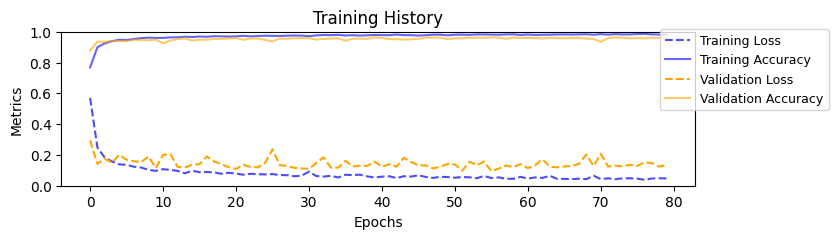

In [ ]:
# Test HParams

'''
shape weights, batch, epochs, model type
'''

params_40 = [ 2, 8, 80, 1, 0.4]

preds_40, model_40, history_40, acc_out_40 = tensor_model_nm(subject_train_df, subject_test_df, params_40, None, False)

plot_history(history_40, 'main')

93/93 [==============================] - 0s 2ms/step
Accuracy score: 0.953


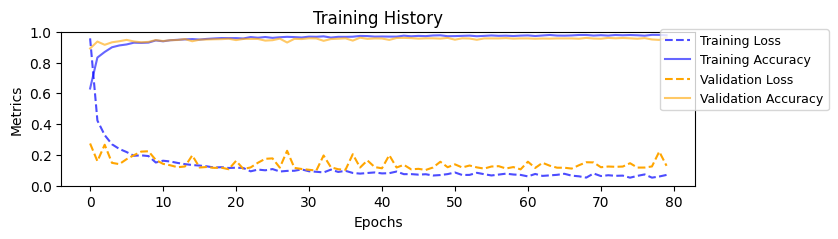

In [ ]:
'''
shape weights, batch, epochs, model type
'''

params_60 = [ 2, 8, 80, 1, 0.6]

preds_60, model_60, history_60, acc_out_60 = tensor_model_nm(subject_train_df, subject_test_df, params_60, None, False)

plot_history(history_60, 'main')

In [ ]:

# Build conf matrix of resultant model

def plot_confusion_matrix(true_labels, predicted_labels):
    classes = 'STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()




Accuracy: 0.953


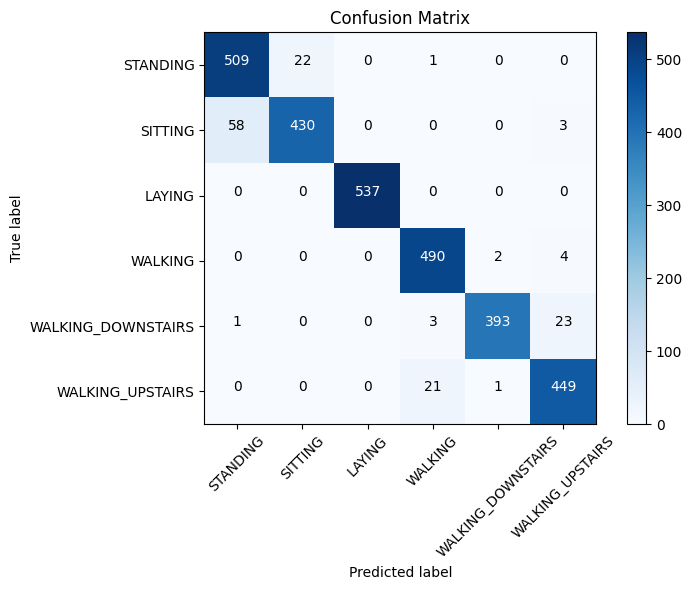

In [ ]:
print(f'Accuracy: {acc_out_60}')

yt_conf_mat = subject_test_df['Activity']

plot_confusion_matrix(yt_conf_mat, np.argmax(preds_60, axis=1))